In [67]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import Dependancies

In [68]:
#!/usr/bin/env python3.11
!python --version

import mesa
print(f"mesa version: {mesa.__version__}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

DEBUGVOCAB = False
DEBUGSTEP = False

Python 3.12.6
mesa version: 3.1.5


# The Naming Game

text

In [69]:
#ideas for own unique approach:
# multiple objects and graph how time until vocab convergence changes?
# different lengths of words and graph difference there?
# limit amount of symbols for words?
# 

Create Random Word

In [70]:
from random import choice
from string import ascii_uppercase

def create_word(min_length=6, max_length=10):
    new_word = ''.join(choice(ascii_uppercase) for _ in range(np.random.randint(min_length, max_length)))
    return new_word

Create Agent

In [71]:
class NamingGameAgent(mesa.Agent):
    def __init__(self, model, m_objects=1):
        super().__init__(model)
        self._m_objects = m_objects
        self.vocabulary = dict()

    def choose_object_and_word(self):
        #chosen from range will always choose 0 index object value, so m_objects = 1 -> chosen object is 0
        chosen_object = np.random.randint(0, self._m_objects)
        
        if chosen_object in self.vocabulary.keys():
            chosen_word = random.choice(self.vocabulary[chosen_object])
        else:
            chosen_word = create_word()
            self.vocabulary[chosen_object] = [chosen_word]
        return chosen_object, chosen_word

    def recognize_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            return False
        if chosen_word in self.vocabulary[chosen_object]:
            return True
        else:
            return False

    def agree_to_word(self, chosen_object, chosen_word):
        self.vocabulary[chosen_object] = [chosen_word]

    def add_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            self.vocabulary[chosen_object] = [chosen_word]
        else:
            self.vocabulary[chosen_object].append(chosen_word)

    def retrieve_vocabulary(self):
        return [f"Object: {key} - words: {value}" for key, value in self.vocabulary.items()]
    
    def word_amount(self):
        return sum([len(word_list) for word_list in self.vocabulary.values()])

Class for computing successrate

In [72]:
class SuccessRate(list):
    def __init__(self, maxlen=10):
        super().__init__()
        self._maxlen = maxlen
    
    def add(self, value):
        if type(value) != int:
            raise TypeError("Only integers are allowed in SuccessRate")
        if len(self) >= self._maxlen:
            self.pop(0)
        self.append(value)
    
    def get_rate(self):
        return sum(self)/len(self) if self else 0

    def get_values(self):
        return list(self)

Create Model

In [73]:
from mesa.datacollection import DataCollector

class NamingGameModel(mesa.Model):
    def __init__(self, N=100, m_objects=1, seed=None, data_resolution=100, detailed_info=True):
        super().__init__(seed=seed)
        self._detailed_info = detailed_info
        self._data_resolution = data_resolution
        self.max_words = 0
        self.max_time = 0
        self.conv_time = -1
        self.num_agents = N
        self.success_rate = SuccessRate(maxlen=200)
        self.datacollector = DataCollector(
            agent_reporters={"Vocabulary": NamingGameAgent.retrieve_vocabulary, 
                             "Word_amount": NamingGameAgent.word_amount},
            model_reporters={"Success_rate": self.success_rate.get_rate,
                             #"Success_rate_values": self.success_rate.get_values,
                             "Total_word_amount": "total_word_amount",
                             "Total_unique_word_amount": "total_unique_word_amount"}
        )
        self.simple_datacollector = DataCollector(
            model_reporters={"Success_rate": self.success_rate.get_rate,
                             "Total_word_amount": "total_word_amount"}
        )
        self.m_objects = m_objects
        NamingGameAgent.create_agents(model=self, n=N, m_objects=m_objects)

    def update_max_words(self):
        if self.max_words < self.total_word_amount:
            self.max_words = self.total_word_amount
            self.max_time = self.steps
    
    def check_convergence(self):
        if self.total_unique_word_amount == self.m_objects and self.conv_time == -1:
            self.conv_time = self.steps
    
    def step(self):
        if self.steps % self._data_resolution == 0:
            if self._detailed_info:
                self.datacollector.collect(self)
            else:
                self.simple_datacollector.collect(self)
                self.update_max_words()
                self.check_convergence()
        speaker, hearer = random.sample(self.agents, 2)
        if self.steps % 100 == 0 and DEBUGVOCAB:
            if speaker.word_amount() != 0:
                print(speaker.word_amount())
                print(speaker.retrieve_vocabulary())
        chosen_object, chosen_word = speaker.choose_object_and_word()
        if hearer.recognize_word(chosen_object, chosen_word):
            self.success_rate.add(1)
            speaker.agree_to_word(chosen_object, chosen_word)
            hearer.agree_to_word(chosen_object, chosen_word)
        else:
            self.success_rate.add(0)
            hearer.add_word(chosen_object, chosen_word)

    @property
    def total_word_amount(self):
        return sum([agent.word_amount() for agent in self.agents])

    @property
    def total_unique_word_amount(self):
        unique_words = set()
        for agent in self.agents:
            for word_list in agent.vocabulary.values():
                unique_words.update(word_list)
        return len(unique_words)


Run Model function

In [74]:
def run_model(N, M, t, iteration, data_resolution=100):
    print(f"Starting model iteration: {iteration}")
    model = NamingGameModel(N, M, data_resolution=data_resolution)
    for i in range(t):
        if i % int(t/10) == 0 and DEBUGSTEP:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return agent_data, model_data

Run model configuration for figure 2

In [75]:
N = 1000
M = 1
t = 100000
DATA_RESOLUTION = 100

RUNS = 3
single_run1 = np.random.randint(0, int(RUNS/2)+1)
single_run2 = min(int(RUNS-1), int(RUNS - single_run1))
print(single_run1)
print(single_run2)

model_df = pd.DataFrame()
single_run1_agent_data, single_run1_model_data = pd.DataFrame(), pd.DataFrame()
single_run2_agent_data, single_run2_model_data = pd.DataFrame(), pd.DataFrame()
for i in range(RUNS):
    agent_data, model_data = run_model(N=N, M=M, t=t, iteration=i+1, data_resolution=DATA_RESOLUTION)
    if i == single_run1:
        single_run1_agent_data = agent_data
        single_run1_model_data = model_data
    if i == single_run2:
        single_run2_agent_data = agent_data
        single_run2_model_data = model_data
    
    if model_df.empty:
        model_df = model_data
    else:
        model_df = (model_df + model_data) / 2

1
2
Starting model iteration: 1
Starting model iteration: 2
Starting model iteration: 3


Datacollection Dataframes

In [76]:
single_run1_agent_data

Vocabulary  Word_amount
Step   AgentID                                                 
100    1                                        []            0
       2                                        []            0
       3        [Object: 0 - words: ['JJCJDQXYM']]            1
       4                                        []            0
       5                                        []            0
...                                            ...          ...
100000 996      [Object: 0 - words: ['WVQVXNDZU']]            1
       997      [Object: 0 - words: ['WVQVXNDZU']]            1
       998      [Object: 0 - words: ['WVQVXNDZU']]            1
       999      [Object: 0 - words: ['WVQVXNDZU']]            1
       1000     [Object: 0 - words: ['WVQVXNDZU']]            1

[1000000 rows x 2 columns]

In [77]:
model_df

,Success_rate,Total_word_amount,Total_unique_word_amount
0,0.00000,189.75,90.75
1,0.00000,365.25,166.25
2,0.00250,531.50,233.00
3,0.00375,679.25,281.00
4,0.00125,816.50,318.25
...,...,...,...
995,1.00000,1000.00,1.00
996,1.00000,1000.00,1.00
997,1.00000,1000.00,1.00
998,1.00000,1000.00,1.00


Create Graphs and Figures

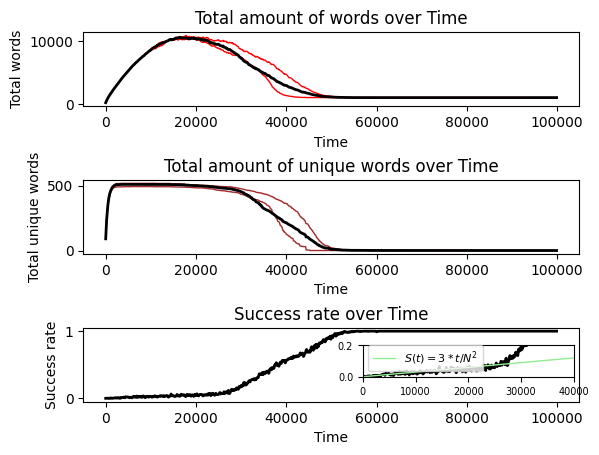

In [78]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

model_df["scaled_index"] = model_df.index * 100
single_run1_model_data["scaled_index"] = single_run1_model_data.index * 100
single_run2_model_data["scaled_index"] = single_run2_model_data.index * 100
fig, axs = plt.subplots(nrows=3)

#figure showing all total words over time
g = sns.lineplot(data=single_run1_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=model_df[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="black", linewidth=2)
g.set(title="Total amount of words over Time", ylabel="Total words", xlabel="Time")

#figure showing all unique words over time
g = sns.lineplot(data=single_run1_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=model_df[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="black", linewidth=2)
g.set(title="Total amount of unique words over Time", ylabel="Total unique words", xlabel="Time")

#figure showing all successful interactions over time
g = sns.lineplot(data=model_df[["Success_rate", "scaled_index"]], x="scaled_index", y="Success_rate", 
                 ax=axs[2], color="black", linewidth=2)
g.set(title="Success rate over Time", ylabel="Success rate", xlabel="Time")

#smaller figure showing succesful interactions over time with overlaid s(t)=3t/N^2
ax_inset = inset_axes(axs[2], width="85%", height="85%", loc='center left',
                      bbox_to_anchor=(0.55, 0.3, 0.5, 0.5), bbox_transform=axs[2].transAxes)

x = model_df["scaled_index"]
inset_y = model_df["Success_rate"]
y = 3 * x / N**2
ax_inset.plot(x, inset_y, 
              color="black", linewidth=2)
ax_inset.plot(x, y, 
              color='lightgreen', label=r'$S(t) = 3*t/{N^2}$', linewidth=1)

#zoom
ax_inset.set_xlim(0, 40000)
ax_inset.set_ylim(0, 0.2)
ax_inset.tick_params(axis='both', labelsize=7)
ax_inset.legend(fontsize=8)

#mark_inset(axs[2], ax_inset, loc1=2, loc2=4, fc="none", ec="0.5") #TODO ask if this is too messy

plt.subplots_adjust(hspace=1)

Run Model for simple datacollection

In [79]:
def run_simple_model(N, M, t, iteration, data_resolution=1000):
    print(f"Starting model iteration: {iteration}")
    model = NamingGameModel(N, M, data_resolution=data_resolution, detailed_info=False)
    for i in range(t):
        if i % int(t/10) == 0 and DEBUGSTEP:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    model_data = model.simple_datacollector.get_model_vars_dataframe()
    return model_data, model.max_words, model.max_time, model.conv_time

Run model configuration for figure 3

In [92]:
n_log = np.logspace(1, 3, 10, base=10, dtype=int)
n_lin = [np.linspace(10**(i-1), 10**i, 10, dtype=int) for i in range(2, 5)]
n_lin = np.concatenate(n_lin)
n_st = [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
n_st_small = [10, 30, 60, 100, 300, 600, 1000, 3000]
M = 1
t = 500000
DATARESOLUTION = 100

s_t_list = []
max_time_list = []
max_words_list = []
conv_time_list = []

for n in n_log:
    _, max_words, max_time, conv_time  = run_simple_model(N=n, M=M, t=t, iteration=n, data_resolution=DATARESOLUTION)
    max_time_list.append(max_time)
    max_words_list.append(max_words)
    conv_time_list.append(conv_time)

df = pd.DataFrame({
    'max_time': max_time_list,
    'conv_time': conv_time_list,
    'max_words': max_words_list
})

for n in n_st_small:
    model_data, _, _, _ = run_simple_model(N=n, M=M, t=t, iteration=n, data_resolution=DATARESOLUTION)

    s_t_list.append(model_data["Success_rate"])

Starting model iteration: 10
Starting model iteration: 16
Starting model iteration: 27
Starting model iteration: 46
Starting model iteration: 77
Starting model iteration: 129
Starting model iteration: 215
Starting model iteration: 359
Starting model iteration: 599
Starting model iteration: 1000
Starting model iteration: 10
Starting model iteration: 30
Starting model iteration: 60
Starting model iteration: 100
Starting model iteration: 300
Starting model iteration: 600
Starting model iteration: 1000
Starting model iteration: 3000


In [93]:
df

,max_time,conv_time,max_words
0,100,100,10
1,100,200,17
2,100,300,47
3,200,700,136
4,400,1500,276
5,1100,2700,533
6,2200,7000,1117
7,4200,11800,2309
8,9500,28800,5008
9,18400,36900,10458


In [94]:
s_t_list

[0       0.505051
 1       0.753769
 2       1.000000
 3       1.000000
 4       1.000000
           ...   
 4995    1.000000
 4996    1.000000
 4997    1.000000
 4998    1.000000
 4999    1.000000
 Name: Success_rate, Length: 5000, dtype: float64,
 0       0.121212
 1       0.216080
 2       0.395000
 3       0.515000
 4       0.575000
           ...   
 4995    1.000000
 4996    1.000000
 4997    1.000000
 4998    1.000000
 4999    1.000000
 Name: Success_rate, Length: 5000, dtype: float64,
 0       0.010101
 1       0.075377
 2       0.165000
 3       0.195000
 4       0.215000
           ...   
 4995    1.000000
 4996    1.000000
 4997    1.000000
 4998    1.000000
 4999    1.000000
 Name: Success_rate, Length: 5000, dtype: float64,
 0       0.010101
 1       0.025126
 2       0.035000
 3       0.060000
 4       0.100000
           ...   
 4995    1.000000
 4996    1.000000
 4997    1.000000
 4998    1.000000
 4999    1.000000
 Name: Success_rate, Length: 5000, dtype: float64,
 0  

Graphs and figures for figure 3

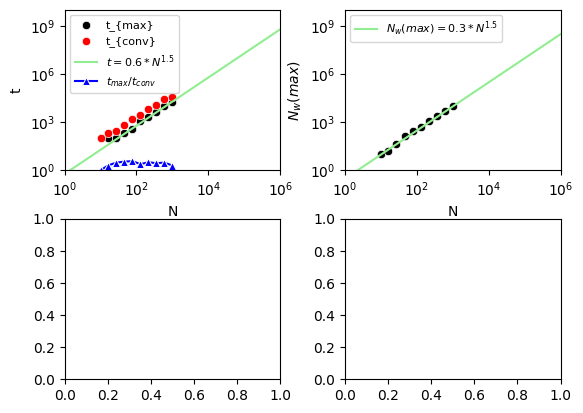

In [155]:
fig, axs = plt.subplots(nrows=2, ncols=2)
t = np.logspace(1, 3, 10, base=10, dtype=int)
t_with0 = np.logspace(0, 6, 20, base=10, dtype=int)
t_n = 0.6*t_with0**1.5
t_d = df["conv_time"] / df["max_time"]

#figure showing max time for multiple agents
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')
g = sns.scatterplot(data=df, x=t, y=df["max_time"], ax=axs[0, 0], color="black", label=r't_{max}')
g = sns.scatterplot(data=df, x=t, y=df["conv_time"], ax=axs[0, 0], color="red", label=r't_{conv}')
g = sns.lineplot(x=t_with0, y=t_n, ax=axs[0, 0], color="lightgreen", label=r'$t = 0.6*N^{1.5}$')
g = sns.lineplot(x=t, y=t_d, ax=axs[0, 0], color="blue", marker='^', label=r'$t_{max}/t_{conv}$')
axs[0,0].legend(loc='upper left', fontsize=8)
axs[0,0].set_ylim(1, 1e10)
axs[0,0].set_xlim(1, 1e6)
g.set(ylabel="t", xlabel="N")

#figure showing max words for multiple agents
t_w = 0.3*t_with0**1.5
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
g = sns.scatterplot(data=df, x=t, y=df["max_words"], ax=axs[0, 1], color="black")
g = sns.lineplot(x=t_with0, y=t_w, ax=axs[0, 1], color="lightgreen", label=r'$N_{w}(max) = 0.3*N^{1.5}$')
axs[0,1].legend(loc='upper left', fontsize=8)
axs[0,1].set_ylim(1, 1e10)
axs[0,1].set_xlim(1, 1e6)
g.set(ylabel=r'$N_{w}(max)$', xlabel="N")

plt.subplots_adjust(hspace=0.3, wspace=0.3)